# Simulated examples for bias detection

In [1]:
import random
from bias_tree import BiasDetectionTree
from data_preparation.movielens_100k import MovieLens100KData

### Prepare MovieLens dataset 

In [2]:
data = MovieLens100KData(data_path='data/ml-100k')
ratings_with_metadata = data.get_ratings_with_metadata()
ratings_with_metadata.head()

,user,item,rating,timestamp,age,gender,profession,zip,title,date,...,Thriller,War,Western,year,user activity,item popularity,age_bucketized,year_bucketized,user activity_bucketized,item popularity_bucketized
0,196,242,3,881250949,49,M,writer,55105,Kolya (1996),24-Jan-1997,...,0,0,0,1997.0,39,117,high,high,low,medium
1,305,242,5,886307828,23,M,programmer,94086,Kolya (1996),24-Jan-1997,...,0,0,0,1997.0,222,117,low,high,medium,medium
2,6,242,4,883268170,42,M,executive,98101,Kolya (1996),24-Jan-1997,...,0,0,0,1997.0,211,117,high,high,medium,medium
3,234,242,4,891033261,60,M,retired,94702,Kolya (1996),24-Jan-1997,...,0,0,0,1997.0,480,117,high,high,high,medium
4,63,242,3,875747190,31,M,marketing,75240,Kolya (1996),24-Jan-1997,...,0,0,0,1997.0,93,117,medium,high,low,medium


### Analyze bias examples

Higher metric for females and crime movies

root=[]: 2.967
├── Crime=[0]: 3.003
└── Crime=[1]: 2.559
    ├── gender=['F']: 0.999
    └── gender=['M']: 3.006



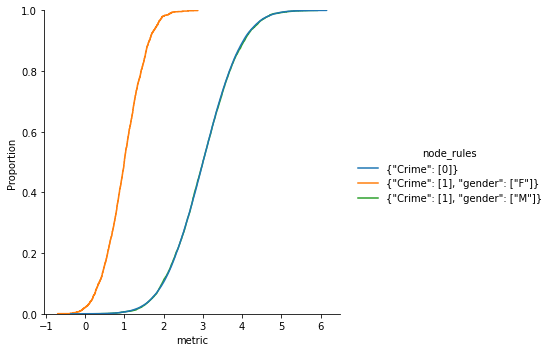

In [3]:
metric_name = 'metric'
metric_distribution_bias_female_crime = lambda x: random.normalvariate(1, .5) if (x['Crime']>0 and x['gender']=='F') \
                                                                                else random.normalvariate(3, 0.8)

ratings_with_metadata[metric_name] = ratings_with_metadata.apply(metric_distribution_bias_female_crime,  1)
bias_detection_tree = BiasDetectionTree(min_child_node_size=1000, alpha=0.01, metric_col=metric_name)
node_metric = bias_detection_tree.analyze_bias(attributes=data.attributes_dict, metric_with_metadata=ratings_with_metadata)

Lower metric for young users

root=[]: 1.022
├── age_bucketized=['high']: 1.499
├── age_bucketized=['low']: 0.5
└── age_bucketized=['medium']: 1.094
    ├── user activity_bucketized=['high', 'low']: 1.123
    │   ├── gender=['F']: 1.157
    │   └── gender=['M']: 1.111
    └── user activity_bucketized=['medium']: 1.039
        ├── year_bucketized=['<missing>', 'low']: 1.063
        └── year_bucketized=['medium', 'high']: 1.024



,count,mean,std,min,25%,50%,75%,max
node_rules,,,,,,,,
"{""age_bucketized"": [""low""]}",34067.0,0.500426,0.100229,0.114791,0.432238,0.500805,0.567977,0.880623
"{""age_bucketized"": [""medium""], ""user activity_bucketized"": [""medium""], ""year_bucketized"": [""medium"", ""high""]}",7111.0,1.023546,0.524437,0.165225,0.506143,1.169494,1.505830,2.285264
"{""age_bucketized"": [""medium""], ""user activity_bucketized"": [""medium""], ""year_bucketized"": [""<missing>"", ""low""]}",4729.0,1.063098,0.521753,0.188187,0.516984,1.251681,1.524606,2.255448
"{""age_bucketized"": [""medium""], ""user activity_bucketized"": [""high"", ""low""], ""gender"": [""M""]}",16137.0,1.110533,0.515274,0.071109,0.536383,1.320646,1.545670,2.261103
"{""age_bucketized"": [""medium""], ""user activity_bucketized"": [""high"", ""low""], ""gender"": [""F""]}",5788.0,1.156929,0.506175,0.171774,0.567469,1.357762,1.558585,2.196354
"{""age_bucketized"": [""high""]}",32166.0,1.498993,0.200324,0.685817,1.363897,1.498446,1.634804,2.237659


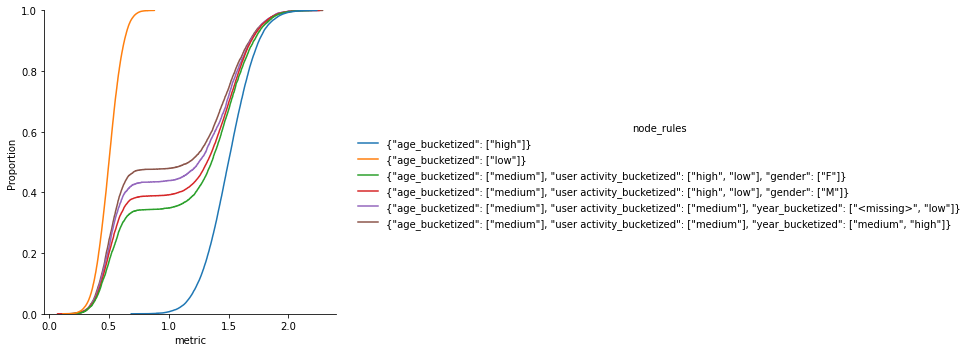

In [4]:
metric_name = 'metric'
metric_distribution_bias_young = lambda x: random.normalvariate(0.5, .1) if x['age']<30 \
                                                                                else random.normalvariate(1.5, .2)

ratings_with_metadata[metric_name] = ratings_with_metadata.apply(metric_distribution_bias_young,  1)
bias_detection_tree = BiasDetectionTree(min_child_node_size=1000, alpha=0.01, metric_col=metric_name)
node_metric = bias_detection_tree.analyze_bias(attributes=data.attributes_dict, metric_with_metadata=ratings_with_metadata)
node_metric

No bias

root=[]: 1.5



,count,mean,std,min,25%,50%,75%,max
node_rules,,,,,,,,
{},100000.0,1.49971,0.099952,1.052384,1.431576,1.499937,1.567323,1.929457


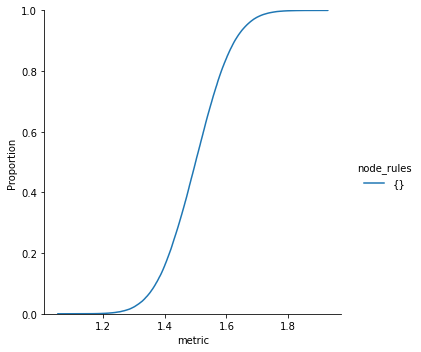

In [5]:
metric_name = 'metric'
metric_normal = lambda x: random.normalvariate(1.5, .1) 

ratings_with_metadata[metric_name] = ratings_with_metadata.apply(metric_normal,  1)
bias_detection_tree = BiasDetectionTree(min_child_node_size=1000, alpha=0.01, metric_col=metric_name)
node_metric = bias_detection_tree.analyze_bias(attributes=data.attributes_dict, metric_with_metadata=ratings_with_metadata)
node_metric